In [1]:
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

#Import a few utility functions...
import sys  
from pathlib import Path
sys.path.insert(0, "../comm_channel")
sys.path.insert(0, "../polling_systems")
sys.path.insert(0, "../geometry")

#So we can import my local libs
import CommChannel as CC
import qos
import pointcloud as PC
import PollingSystem as PS
import MarkovianRP as MRP
import dtr

In [22]:
#setup quality of service requirements using reasonable values
F5GHz, F2_4GHz = 5, 2.4 #typical wifi frequencies are 2.4, 5, and sometiems 6 GHz
MOBILE_TX_POWER = qos.Pwr(30)#100-200mW (20-23 dBm) pretty typical, with 1W (30dBm) the absolute maximum
print(MOBILE_TX_POWER)
r = 6#any of 2, 4, 6, or 8
rx_noise = qos.Pwr(-85)#based on Yan and MostofiTWC13 #1e-10#
print(rx_noise)
BER = 1e-6
GAMMA_TH = qos.QoSReq(BER, r, rx_noise).thresholdChannelGain(MOBILE_TX_POWER)
print(GAMMA_TH)
print('SNR Threshold: %d'%(GAMMA_TH+MOBILE_TX_POWER.dBm - rx_noise.dBm))

30.000000 dBm	0.000000 dBW	1000.000000 mW	1.000000 W
-85.000000 dBm	-115.000000 dBW	0.000000 mW	0.000000 W
-87.90174759231483
SNR Threshold: 27


Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.


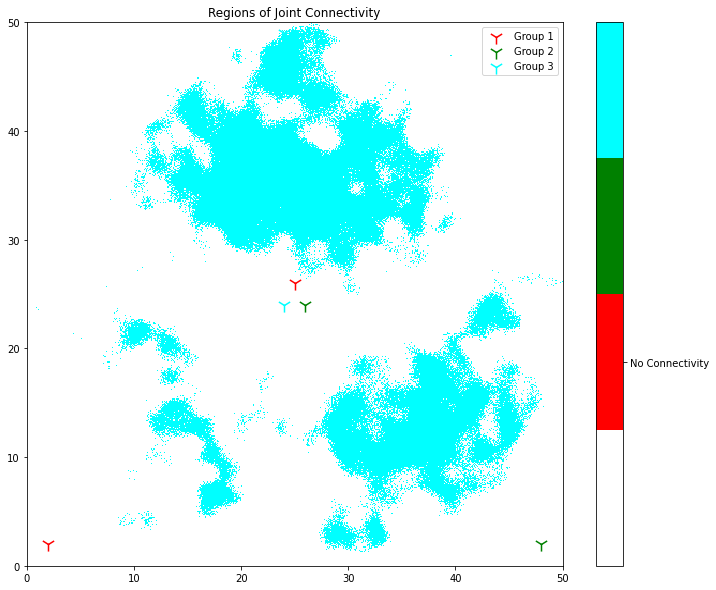

In [23]:
#Setup the system:

#For now, use same channel params, basd on the San Francisco measurements
nPL = 4.2  
kPL = -35

decorrSH = 3.09    
alpha = 8.41
sigmaSH = np.sqrt(alpha)
psdAtFC = 30

lam = 0.125
kRic = 10
decorrMP = 0.4*lam         
corrMP = 1
#sigmaMP = 3
sigmaMP = 1



#6 remote stations
qBase = np.array([[25,26], [2,2], [26,24], [48,2], [24, 24], [24,49]])
cps = [CC.ChannelParams(qBase[i], nPL, kPL, sigmaSH, decorrSH, decorrMP, lam,
                      kRic, corrMP, psdAtFC, sigmaMP) for i in range(len(qBase))]

x_max = 50
x_min = 0
y_max = 50
y_min = 0
region = [x_max, x_min, y_max, y_min]

#res = 2/decorrMP
res = 10
#Create Comm Channels
ccs = [CC.CommChannel(cps[i], region, res) for i in range(len(cps))]
for cc in ccs:
        cc.generateSH();cc.generateMP(2)

#now display the regions so we know if this is going to work for us
color_array=['white', 'red', 'green', 'cyan']
#plot the connectivity fields
cfs = [cc.getConnectionField(GAMMA_TH) for cc in ccs]
r1 = 1*cfs[0]*cfs[1]; r2 = 1*cfs[2]*cfs[3]; r3 = 1*cfs[4]*cfs[5];
cmap = ListedColormap(color_array)
ticks =[0.75/2,1.5-0.75/2, 1.5+0.75/2, 3-0.75/2]
tick_labels = ['No Connectivity','X1', 'X2', 'X3']
CC.plotField(region, r1+r2+r3, 'Regions of Joint Connectivity', cmap=cmap,
             ticks=ticks, tick_labels = tick_labels, do_show=False)

for i in range(3):
    plt.scatter([qBase[2*i][0], qBase[2*i+1][0]], [qBase[2*i][1], qBase[2*i+1][1]],
                label='Group %d'%(i+1), color=color_array[i+1], marker='1', s=200)
plt.legend()    
plt.show()

In [96]:
#JUST USE THE STORED CHANNELS! TRIPPLE PLZ
#%store -r pcs

Stored 'pcs' (list)


In [24]:
#Create the predicted channel
pct_sample = 0.005
n_samples = int(pct_sample*(x_max - x_min)*(y_max - y_min)*res**2)
print('Drawing %d samples from each region'%(n_samples))
pcs = []
for cc in ccs:
    xs, vals = cc.sampleChannel(n_samples)
    pcs.append(CC.PredictedChannel(cc.cp, cc.region, res, xs, vals))
    print('Completed PredictedChannel %d'%(len(pcs)))
%store pcs

Drawing 1250 samples from each region
Completed PredictedChannel 1
Completed PredictedChannel 2
Completed PredictedChannel 3
Completed PredictedChannel 4
Completed PredictedChannel 5
Completed PredictedChannel 6


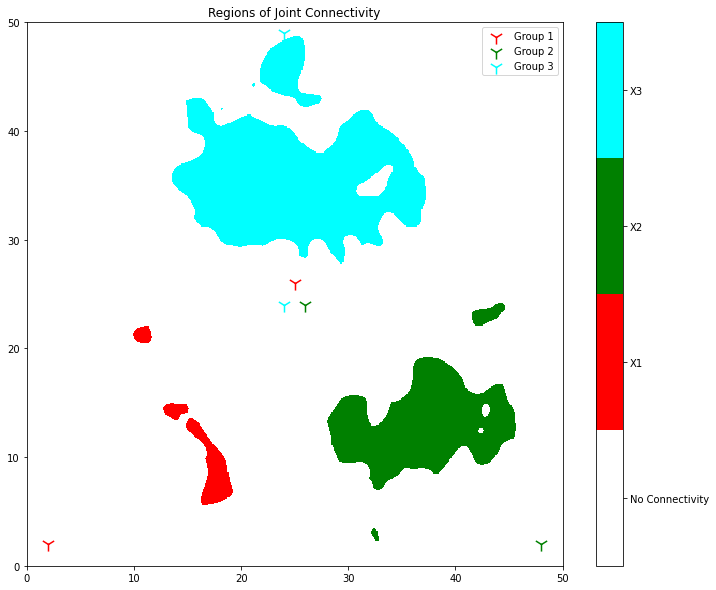

In [25]:
p_th = 0.7
for pc in pcs:
    pc.setPth(p_th)

#now display the regions so we know if this is going to work for us
color_array=['white', 'red', 'green', 'cyan']
#plot the connectivity fields
pfs = [pc.getPConField(GAMMA_TH) for pc in pcs]
r1 = 1*(pfs[0]*pfs[1]>p_th); r2 = 2*(pfs[2]*pfs[3]>p_th); r3 = 3*(pfs[4]*pfs[5]>p_th);
cmap = ListedColormap(color_array)
ticks =[0.75/2,1.5-0.75/2, 1.5+0.75/2, 3-0.75/2]
tick_labels = ['No Connectivity','X1', 'X2', 'X3']
CC.plotField(region, r1+r2+r3, 'Regions of Joint Connectivity', cmap=cmap,
             ticks=ticks, tick_labels = tick_labels, do_show=False)

for i in range(3):
    plt.scatter([qBase[2*i][0], qBase[2*i+1][0]], [qBase[2*i][1], qBase[2*i+1][1]],
                label='Group %d'%(i+1), color=color_array[i+1], marker='1', s=200)
plt.legend()    
plt.show()

In [27]:
from importlib import reload 
reload(dtr)
# reload(MRP)
# reload(PS)
reload(PC)

<module 'pointcloud' from '/home/win/dev/CommMotionPlanning/python/touring_relay/../geometry/pointcloud.py'>

Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
15 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Found hole
Found hole
Constructed 3 possibly non-convex polygons
38 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Found hole
Constructed 4 possibly non-convex polygons
53 total subregions
Optimized Policy Waiting Time: 69.2336
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 1 logical processors, using up to 1 threads
Optimize a model with 539 rows, 115 columns and 1659 nonzeros
Model fingerprint: 0x16e69282
Model has 3 quadratic constraints
Variable types: 9 continuous, 106 integer (106 binary)
Coefficient statistics:
  Matrix range     [4e-02, 1e+04]
  QMatrix range    [1e+00, 2e+00]
  Objective range  [3e-02, 1e-01]
  Bounds range     [1e+00, 1e

     0     0    0.14600    0   25    5.30288    0.14600  97.2%     -    0s
     0     0    0.15554    0   23    5.30288    0.15554  97.1%     -    0s
     0     0    0.15605    0   23    5.30288    0.15605  97.1%     -    0s
     0     0    0.15667    0   24    5.30288    0.15667  97.0%     -    0s
     0     0    0.15730    0   23    5.30288    0.15730  97.0%     -    0s
     0     0    0.15799    0   23    5.30288    0.15799  97.0%     -    0s
H    0     0                       4.6950359    0.15799  96.6%     -    0s
     0     0    0.17803    0   25    4.69504    0.17803  96.2%     -    0s
     0     0    0.17820    0   24    4.69504    0.17820  96.2%     -    1s
     0     0    0.17843    0   24    4.69504    0.17843  96.2%     -    1s
     0     0    0.17849    0   24    4.69504    0.17849  96.2%     -    1s
     0     0    0.17850    0   23    4.69504    0.17850  96.2%     -    1s
     0     0    0.20334    0   22    4.69504    0.20334  95.7%     -    1s
H    0     0             

   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 1 logical processors, using up to 1 threads
Optimize a model with 539 rows, 115 columns and 1659 nonzeros
Model fingerprint: 0x3f23f248
Model has 3 quadratic constraints
Variable types: 9 continuous, 106 integer (106 binary)
Coefficient statistics:
  Matrix range     [4e-02, 1e+04]
  QMatrix range    [1e+00, 2e+00]
  Objective range  [3e-02, 2e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 44 rows and 0 columns
Presolve time: 0.13s
Presolved: 549 rows, 130 columns, 3321 nonzeros
Presolved model has 15 bilinear constraint(s)
Variable types: 24 continuous, 106 integer (106 binary)

Root relaxation: objective 0.000000e+00, 36 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.

     0     0    0.08870    0   24    5.65467    0.08870  98.4%     -    1s
     0     0    0.08875    0   23    5.65467    0.08875  98.4%     -    1s
     0     0    0.10164    0   23    5.65467    0.10164  98.2%     -    1s
     0     2    0.10197    0   23    5.65467    0.10197  98.2%     -    1s
H   70    62                       4.9231793    0.10217  97.9%   5.9    1s
H  213    83                       3.8891125    0.18093  95.3%   5.7    1s
H 1032   232                       3.7184989    0.80645  78.3%   6.8    2s
H 1035   222                       3.7182363    1.15242  69.0%   6.8    2s
  3429   429    3.34300   30   11    3.71824    2.79066  24.9%   5.8    5s

Cutting planes:
  Implied bound: 4
  PSD: 16

Explored 5102 nodes (30107 simplex iterations) in 6.96 seconds
Thread count was 1 (of 1 available processors)

Solution count 9: 3.71824 3.7185 3.88911 ... 8.16217

Optimal solution found (tolerance 1.00e-04)
Best objective 3.718236292398e+00, best bound 3.717902977439e+00, gap

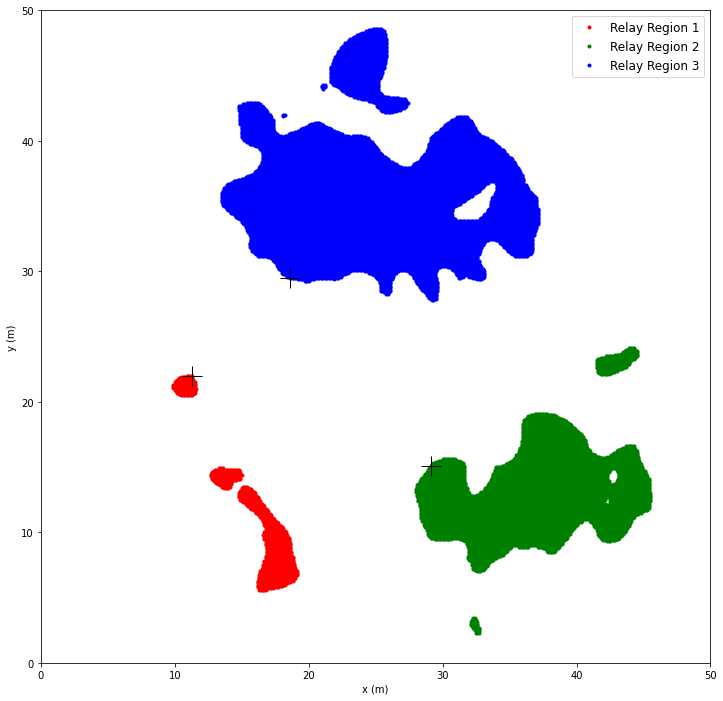

Optimized Waiting Time: 32.0389


In [28]:
bandwidth = 2#leave bandwidth in MHz*1000000#give ourselfes 2MHz of BW
beta = 1/r*bandwidth
#make it easy to ensure stability by givein arrivals in terms of beta
els = [0.2/beta, 0.05/beta, 0.1/beta]
sys = dtr.DTR(pcs, els, beta, th=GAMMA_TH)
pi, x = sys.optimize(x_opt_method=3)

Size of convex partition: 15
Size of convex partition: 38
Size of convex partition: 53


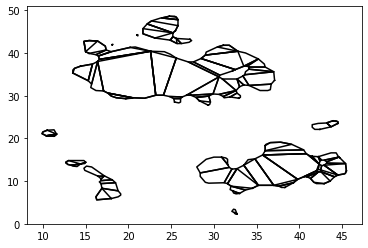

In [29]:


for reg in sys.cregions:
    n_cnvx = 0
    for p in reg.polygons:
        n_cnvx += len(p.cnvx_partition)
    print('Size of convex partition: %d'%(n_cnvx))
    reg.plot_polys()

In [80]:
def plot_optimization(dtr, x, qbase, save = False, ls=12):
    
    fs=20
    plt.rcParams['font.size'] = fs
    fig = plt.figure(figsize=(12,12))
    #plot the connectivity fields
    colors = ['xkcd:aqua', 'xkcd:coral', 'xkcd:wheat', 'c']
    for i in range(dtr.n):
        Xi = dtr.Xis[i]
        pts = Xi['points']
        plt.plot(pts[:,0],  pts[:,1], '.', color=colors[i])
        #dummy series for better legend formatting
        plt.plot([-100], [-100], '.', color=colors[i], markersize=20, label='Relay Region %d'%(i+1))
        reg = sys.cregions[i]
        reg.plot_polys()
        
    
    #plot base stations
    for i in range(3):
        plt.scatter([qBase[2*i][0], qBase[2*i+1][0]], [qBase[2*i][1], qBase[2*i+1][1]],
                    color=colors[i], marker='v', s=200, edgecolor='k')
    
    #dummy series for legend formatting
    plt.scatter([-100], [-100], marker='v', s=200, color='w', edgecolor='k', label='Station/Sensor Pairs')
    plt.plot(x[:,0], x[:,1], '*k', markersize=16, label='Final Relay Postitions')
    plt.xlim(region[1], region[0])
    plt.ylim(region[3], region[2])
    plt.xlabel('x (m)', fontsize=fs)
    plt.ylabel('y (m)', fontsize=fs)
    
    plt.legend(prop={'size':fs}, loc='upper right')
    if save:
        plt.savefig('sim_pairs_%d_pth_%.2f_gammath_%d_alt.eps'%(dtr.n, dtr.p_th, dtr.gamma_th),format='eps')
    plt.show()
            

#plot_optimization(sys, x, qBase, save=True)        

In [79]:
els

[0.6000000000000001, 0.15000000000000002, 0.30000000000000004]

Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
17 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Found hole
Found hole
Constructed 3 possibly non-convex polygons
38 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Found hole
Constructed 4 possibly non-convex polygons
57 total subregions
Optimized Policy Waiting Time: 56.7028
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 1 logical processors, using up to 1 threads
Optimize a model with 574 rows, 121 columns and 1764 nonzeros
Model fingerprint: 0x4235cc50
Model has 3 quadratic constraints
Variable types: 9 continuous, 112 integer (112 binary)
Coefficient statistics:
  Matrix range     [4e-02, 1e+04]
  QMatrix range    [1e+00, 2e+00]
  Objective range  [4e-05, 3e-02]
  Bounds range     [1e+00, 1e

* 1051   159              70       0.9568723    0.28192  70.5%   7.1    1s
* 1052   158              68       0.9568294    0.28192  70.5%   7.1    1s
* 1107   143              81       0.8886427    0.31502  64.6%   6.9    2s
* 1109   141              79       0.8886356    0.31502  64.6%   6.9    2s
H 1147   162                       0.8261821    0.61679  25.3%   6.8    2s
* 1288   183              49       0.8261821    0.75176  9.01%   6.7    2s
* 2248    97              49       0.8261821    0.78722  4.72%   4.8    2s

Cutting planes:
  PSD: 6

Explored 3419 nodes (13195 simplex iterations) in 3.22 seconds
Thread count was 1 (of 1 available processors)

Solution count 10: 0.826182 0.826182 0.888636 ... 1.17577

Optimal solution found (tolerance 1.00e-04)
Best objective 8.261821261344e-01, best bound 8.261005898833e-01, gap 0.0099%
Transition probabilities:  [0.001      0.90658401 0.09241599]
Points:  [[18.30000048  9.99999948]
 [41.5        23.2       ]
 [36.3        31.2       ]]
Opt

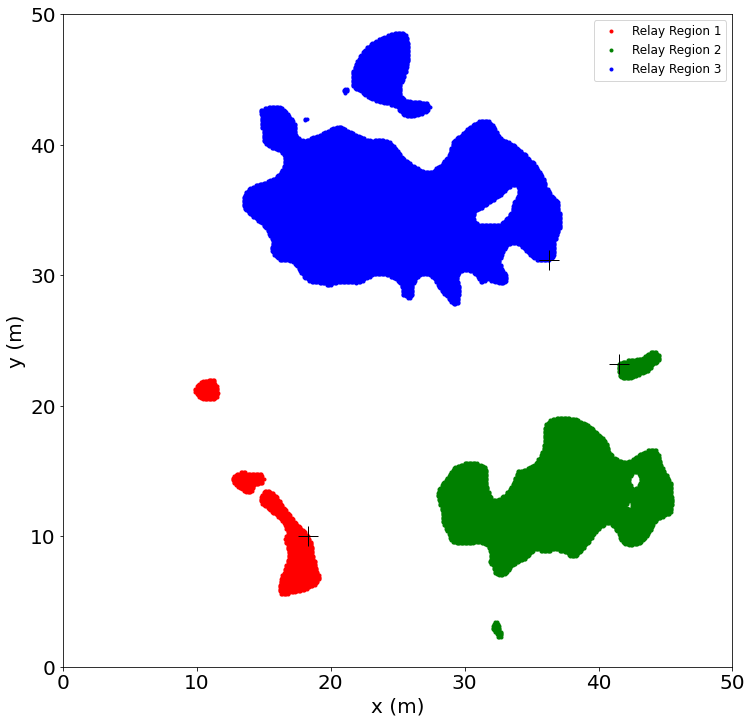

Optimized Waiting Time: 21.9513


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


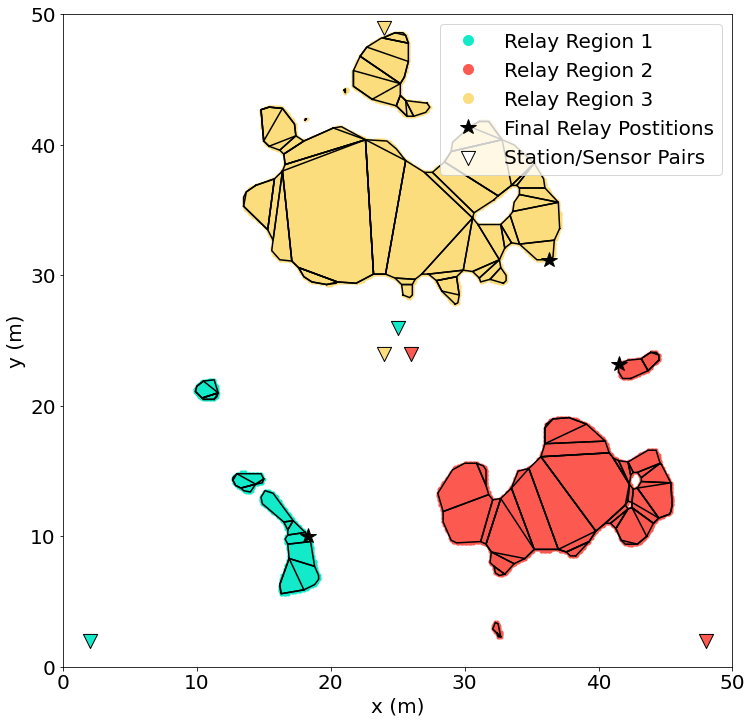

In [92]:
#now run with different els
els2 = [0.0001/beta, 0.4/beta, 0.3/beta]
sys2 = dtr.DTR(pcs, els2, beta, th=GAMMA_TH)
pi2, x2 = sys2.optimize(x_opt_method=3)
plot_optimization(sys2, x2, qBase, save=True)  

<ipython-input-93-7510d4e523e0>:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "*k" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x2[:,0], x2[:,1], '*k', color='gold', markersize=16, label='Final Relay Postitions')


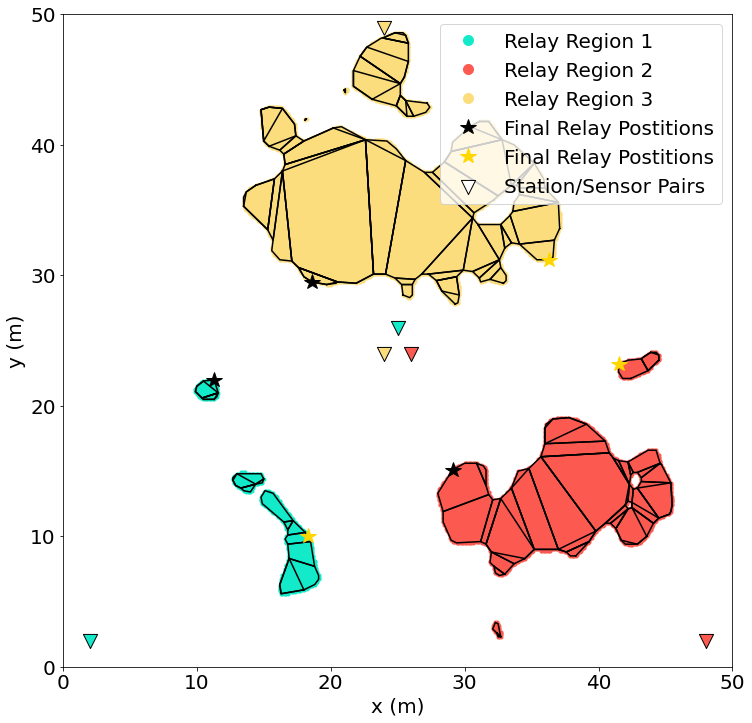

In [93]:
fs=20
plt.rcParams['font.size'] = fs
fig = plt.figure(figsize=(12,12))
#plot the connectivity fields
colors = ['xkcd:aqua', 'xkcd:coral', 'xkcd:wheat', 'c']
for i in range(sys.n):
    Xi = sys.Xis[i]
    pts = Xi['points']
    plt.plot(pts[:,0],  pts[:,1], '.', color=colors[i])
    #dummy series for better legend formatting
    plt.plot([-100], [-100], '.', color=colors[i], markersize=20, label='Relay Region %d'%(i+1))
    reg = sys.cregions[i]
    reg.plot_polys()


#plot base stations
for i in range(3):
    plt.scatter([qBase[2*i][0], qBase[2*i+1][0]], [qBase[2*i][1], qBase[2*i+1][1]],
                color=colors[i], marker='v', s=200, edgecolor='k')

#dummy series for legend formatting
plt.scatter([-100], [-100], marker='v', s=200, color='w', edgecolor='k', label='Station/Sensor Pairs')
plt.plot(x[:,0], x[:,1], '*k', markersize=16, label='Final Relay Postitions')
plt.plot(x2[:,0], x2[:,1], '*k', color='gold', markersize=16, label='Final Relay Postitions')
plt.xlim(region[1], region[0])
plt.ylim(region[3], region[2])
plt.xlabel('x (m)', fontsize=fs)
plt.ylabel('y (m)', fontsize=fs)

plt.legend(prop={'size':fs}, loc='upper right')
plt.show()